# Introduction

The Integrated Canine Data Commons (ICDC) provides multiple avenues for users to access and use data. In addtion to the [ICDC Website](https://https://caninecommons.cancer.gov/#/), there are REST and GraphQL APIs.  In particular, the GraphQL API allows users to understand what is in the ICDC database and create custom queries that return the exact data that the researcher is intrested in.

In this notebook we go through some simple examples that demonstrate how to access data through the GraphQL API, including data that are not availble in the web interface.

In [1]:
import sys
!{sys.executable} -m pip install requests
!{sys.executable} -m pip install pprint
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install plotly
!{sys.executable} -m pip install matplotlib

ERROR: Could not find a version that satisfies the requirement pprint (from versions: none)
ERROR: No matching distribution found for pprint


In [2]:
import requests
import icdcQueries as icdc #This file contains the GraphQL queries used in this demonstration.
import pprint
import pandas as pd
import numpy as np
import matplotlib
import plotly
import plotly.express as px
import plotly.graph_objects as go
#from urllib2 import Request, urlopen
import json
from IPython.display import display, HTML
icdc.init()

In [3]:
%matplotlib inline

In [4]:
#General query interface
def runQuery(query):
    
    endpoint = "https://caninecommons.cancer.gov/v1/graphql/"
    
    request = requests.post(endpoint, json={'query': query})
    
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed code {}. {}".format(request.status_code,query))

In [5]:
#Flatten a JSON object into a table
def flattenJSON(jsondata):
    flatdata = {}

    def flatten(x, name=''):
        if type(x) is dict:
            for a in x:
                flatten(x[a], name + a + '_')
        elif type(x) is list:
            i = 0
            for a in x:
                flatten(a, name + str(i) + '_')
                i +=1
        else:
            flatdata[name] = x

    flatten(jsondata)
    return flatdata

In [6]:
def getDataframe(query):
    #Provide a GraphQL query and get a pandas dataframe back.  Assumes a query based on case
    
    #Run the GraphQL query
    jsondata = runQuery(query)
    
    #Flatten the JSON and push it into a dataframe
    #finaldata = pd.DataFrame(flattenJSON(case) for case in jsondata['data']['case'])
    finaldata = pd.json_normalize(jsondata['data']['case'])
    return finaldata

In [7]:
def scatterPlot(xaxis, yaxis):
    #Use Plotly to create a basic scatter plot
    
    dataframe = getDataframe(icdc.demo_query)
    
    dataframe.plot(x=xaxis, y=yaxis, kind='scatter')
    
    #figure = px.scatter(dataframe, x=xaxis, y=yaxis)
   #figure.show()

In [8]:
def histPlot(cat):
    dataframe = getDataframe(icdc.table_demo)
    #dataframe.plot()
    
    age = dataframe[cat]
    age.plot(kind='hist')
    

In [9]:
def niceTable():
    #Use Plotly to create a presentation quality table
    
    icdc.init()
    variables = None
    
    df = getDataframe(icdc.table_demo)
    
    figure = go.Figure(data=[go.Table(header=dict(values=list(df.columns),align="left"), cells=dict(values=df.transpose().values.tolist()))])
    
    #figure = go.Figure(data=[go.Table(header=dict(values=list(df.columns)), 
     #                                 cells=dict(values=[df[k].tolist() for k in df.columns]))])
    
    figure.show()

In [10]:
def niceTable2():
    icdc.init()
    
    df = getDataframe(icdc.table_demo)
    display(HTML(df.to_html()))

In [11]:
def queryList():
    # Demonstate how to query for all fields in ICDC
    
    data = runQuery(icdc.all_queries)
    pprint.pprint(data)

In [12]:
def dataframePrint():
    
    dataframe = getDataframe(icdc.demo_query)
    pprint.pprint(dataframe)

In [13]:
def dataframeColumns():
    dataframe = getDataframe(icdc.demo_query)
    #for col in dataframe.columns:
    #    print(col)
    
    colList = list(dataframe)
    print(colList)

# GraphQL Introspection
GraphQL provides a service calls **introspection** that allows users to ask the system what fields are available to query.  This service allows users to browse the database schema and construct the queries to return the information they're interested in.

The result below shows all of the fields in ICDC that users can access

In [14]:
queryList()

{'data': {'__schema': {'queryType': {'fields': [{'description': None,
                                                 'name': 'AgeCaseCount'},
                                                {'description': None,
                                                 'name': 'BreedCaseCount'},
                                                {'description': None,
                                                 'name': 'CaseDetail'},
                                                {'description': None,
                                                 'name': 'CaseOverview'},
                                                {'description': None,
                                                 'name': 'DiagnosisCaseCount'},
                                                {'description': None,
                                                 'name': 'DiseaseSiteCaseCount'},
                                                {'description': None,
                                                 'na

# Getting data from the API

Even if  data aren't presented in the ICDC graphical interface, they are avaialble via the API for users to access and analyze.  In the example below, the ICDC API was queried to provide a variety of information about each case in ICDC such as the cohort they were assigned to, the diagnosis, and any associated files. 

Since the ICDC API returns data in JSON format, it is easy to transform the data into commonly used anayltical tools.  In the example below, data about each case was retrieved from ICDC and put into a Pandas dataframe, a commonly used Python data management tool.

In [15]:
dataframePrint()

    visits                case_id  \
0       []          COTC007B-0505   
1       []          COTC007B-1605   
2       []          COTC007B-0610   
3       []          COTC007B-0408   
4       []          COTC007B-0506   
..     ...                    ...   
220     []  NCATS-COP01-CCB070020   
221     []  NCATS-COP01-CCB070034   
222     []  NCATS-COP01-CCB070102   
223     []  NCATS-COP01-CCB080012   
224     []  NCATS-COP01-CCB080018   

                                             diagnoses  \
0    [{'stage_of_disease': 'IIIa', 'concurrent_dise...   
1    [{'stage_of_disease': 'IIIa', 'concurrent_dise...   
2    [{'stage_of_disease': 'IIIa', 'concurrent_dise...   
3    [{'stage_of_disease': 'IIIa', 'concurrent_dise...   
4    [{'stage_of_disease': 'IIIa', 'concurrent_dise...   
..                                                 ...   
220  [{'stage_of_disease': 'Unknown', 'concurrent_d...   
221  [{'stage_of_disease': 'Unknown', 'concurrent_d...   
222  [{'stage_of_disease': 'Unkno

In [16]:
dataframeColumns()

['visits', 'case_id', 'diagnoses', 'samples', 'cohort.cohort_description', 'cohort.cohort_dose', 'demographic.neutered_indicator', 'demographic.patient_age_at_enrollment', 'demographic.sex', 'demographic.weight', 'demographic.breed', 'cohort']


# Analyzing data

Users can combine common tools such as Pandas and Plotly to graph data retrived from the ICDC API.  While this example uses Python, GraphQL is language agnostsic and users can access the IDCD API using the language of their choice.

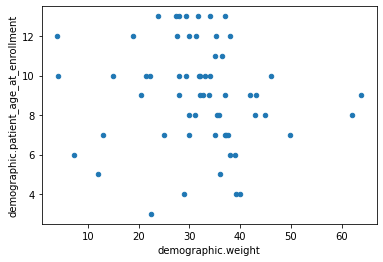

In [17]:
xaxis = "demographic.weight"
yaxis = "demographic.patient_age_at_enrollment"
scatterPlot( xaxis, yaxis)

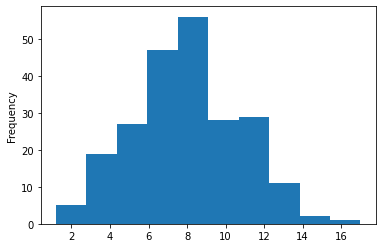

In [18]:

cat = "demographic.patient_age_at_enrollment"
histPlot(cat)

Similarly, these tools can be used to produced presentation-ready tables of selected data.

In [19]:
niceTable2()

,case_id,demographic.patient_age_at_enrollment,demographic.sex,demographic.weight,demographic.breed
0,COTC007B-0505,5.2,Male,NaN,Rottweiler
1,COTC007B-1605,4.0,Male,NaN,Mixed Breed
2,COTC007B-0610,5.4,Male,NaN,Cavalier King Charles Spaniel
3,COTC007B-0408,5.0,Female,NaN,Chesapeake Bay Retriever
4,COTC007B-0506,5.0,Female,NaN,Mixed Breed
5,COTC007B-0601,7.8,Male,NaN,English Setter
6,COTC007B-0203,8.0,Male,NaN,Black and Tan Coonhound
7,COTC007B-1601,5.9,Male,NaN,Bullmastiff
8,COTC007B-0206,5.9,Female,NaN,Golden Retriever
9,COTC007B-0208,7.3,Female,NaN,German Shepherd Dog
